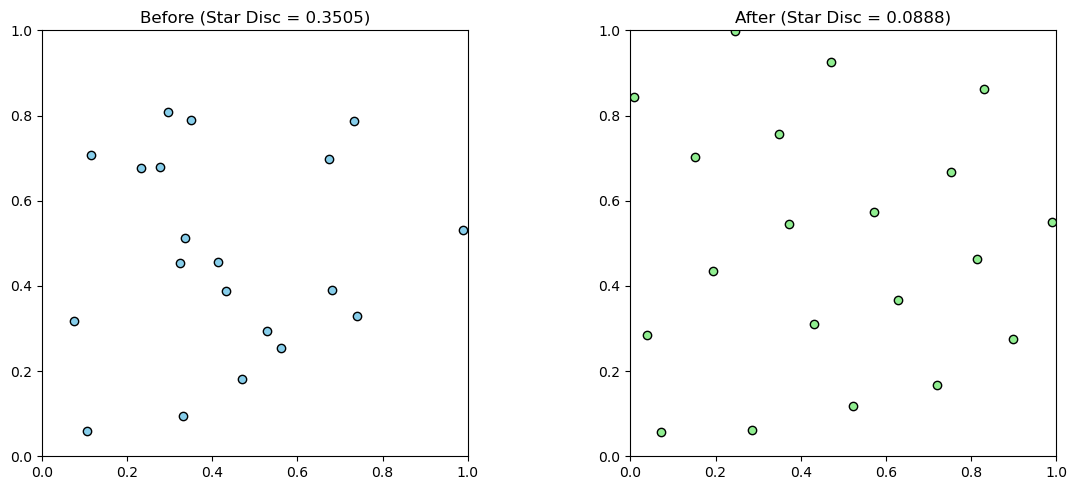

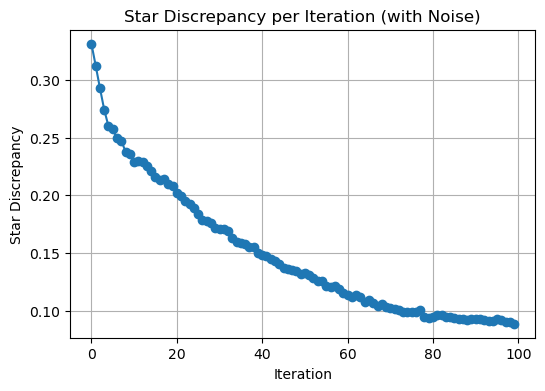

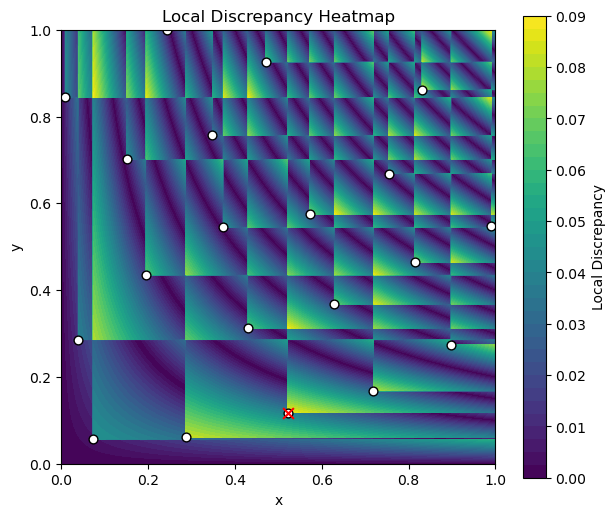

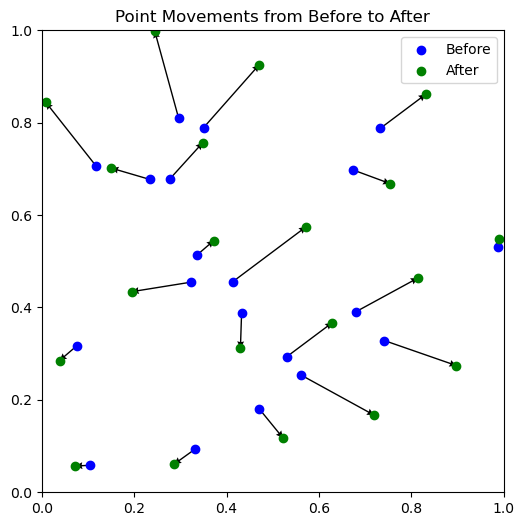

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# ———————————————————————
# 1) Define necessary utilities
# ———————————————————————

def star_disc(P):
    n = P.shape[0]
    pts_ext = np.vstack([P, [1.0, 1.0]])
    disc = 0.0
    for i in range(n + 1):
        for j in range(n + 1):
            x, y = pts_ext[i,0], pts_ext[j,1]
            count  = np.sum((P[:,0] <= x) & (P[:,1] <= y))
            count2 = np.sum((P[:,0] <  x) & (P[:,1] <  y))
            disc = max(disc,
                       count/n - x*y,
                       x*y - count2/n)
    return disc

def bump_penalty(P):
    n = P.shape[0]
    r0 = np.sqrt(1/n)
    pen = 0.0
    for i in range(n):
        for j in range(i+1, n):
            dij = np.linalg.norm(P[i] - P[j])
            u = dij / r0
            if u < 1:
                pen += np.exp(1.0 / (u*u - 1.0))
    return pen

def objective_with_bump(P, alpha=1e-3):
    return star_disc(P) + alpha * bump_penalty(P)

def project_to_unit_cube(P):
    return np.clip(P, 0, 1 - 1e-8)

def heatmap_from_array(P):
    X = np.linspace(0, 1, 1001)
    Y = np.linspace(0, 1, 1001)
    Z = np.zeros((1001, 1001))
    for i, xi in enumerate(X):
        for j, yj in enumerate(Y):
            no = np.sum((P[:,0] <  xi) & (P[:,1] <  yj))
            nc = np.sum((P[:,0] <= xi) & (P[:,1] <= yj))
            Z[j, i] = max(xi*yj - no/P.shape[0], nc/P.shape[0] - xi*yj)
    plt.figure(figsize=(7,6))
    cs = plt.contourf(X, Y, Z, levels=40, cmap="viridis")
    plt.colorbar(cs, label="Local Discrepancy")
    plt.scatter(P[:,0], P[:,1], c="white", s=40, edgecolors="k")
    jm, im = np.unravel_index(Z.argmax(), Z.shape)
    plt.scatter(X[im], Y[jm], c="red", s=60, marker="x")
    plt.title("Local Discrepancy Heatmap")
    plt.xlabel("x"); plt.ylabel("y")
    plt.gca().set_aspect("equal")
    plt.show()

# ———————————————————————
# 2) PGD with noise injection on plateau
# ———————————————————————

def PGD_bump_noise(P0, lr=1e-2, alpha=1e-1, steps=100, delta=1e-5,
                   thr=1e-5, noise_scale=0.00):
    P = P0.copy()
    history = []
    prev_disc = star_disc(P)
    
    for t in range(steps):
        # finite-difference gradient
        grad = np.zeros_like(P)
        for i in range(P.shape[0]):
            for j in range(P.shape[1]):
                orig = P[i,j]
                P[i,j] = orig + delta
                f_plus = objective_with_bump(P, alpha)
                P[i,j] = orig - delta
                f_minus = objective_with_bump(P, alpha)
                grad[i,j] = (f_plus - f_minus) / (2*delta)
                P[i,j] = orig

        # gradient step + projection
        P -= lr * grad
        P = project_to_unit_cube(P)

        # compute discrepancy
        curr_disc = star_disc(P)
        history.append(curr_disc)

        # noise injection if plateau
        if abs(curr_disc - prev_disc) < thr:
            P += np.random.normal(scale=noise_scale, size=P.shape)
            P = project_to_unit_cube(P)
        prev_disc = curr_disc

    return P, history

# ———————————————————————
# 3) Run optimization and visualize
# ———————————————————————

np.random.seed(69)
n = 20
P0 = np.random.rand(n, 2)

initial_disc = star_disc(P0)
P_opt, history = PGD_bump_noise(P0, lr=1e-2, alpha=1e-1, steps=100,
                               delta=1e-5, thr=1e-5, noise_scale=0.00)
final_disc = star_disc(P_opt)

# Plot 1: Before vs After Scatter
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(P0[:,0], P0[:,1], c="skyblue", edgecolor="k")
plt.title(f"Before (Star Disc = {initial_disc:.4f})")
plt.xlim(0,1); plt.ylim(0,1); plt.gca().set_aspect("equal")

plt.subplot(1,2,2)
plt.scatter(P_opt[:,0], P_opt[:,1], c="lightgreen", edgecolor="k")
plt.title(f"After (Star Disc = {final_disc:.4f})")
plt.xlim(0,1); plt.ylim(0,1); plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()

# Plot 2: Star Discrepancy per Iteration
plt.figure(figsize=(6,4))
plt.plot(history, marker="o", linestyle="-")
plt.title("Star Discrepancy per Iteration (with Noise)")
plt.xlabel("Iteration")
plt.ylabel("Star Discrepancy")
plt.grid(True)
plt.show()

# Plot 3: Heatmap of Local Discrepancy
heatmap_from_array(P_opt)

# Plot 4: Movement Arrows
plt.figure(figsize=(6,6))
plt.scatter(P0[:,0], P0[:,1], c="blue", label="Before", zorder=1)
plt.scatter(P_opt[:,0], P_opt[:,1], c="green", label="After", zorder=1)
# arrows
dx = P_opt[:,0] - P0[:,0]
dy = P_opt[:,1] - P0[:,1]
plt.quiver(P0[:,0], P0[:,1], dx, dy, angles='xy', scale_units='xy', scale=1,
           width=0.003, headwidth=5, zorder=0)
plt.title("Point Movements from Before to After")
plt.xlim(0,1); plt.ylim(0,1); plt.gca().set_aspect("equal")
plt.legend()
plt.show()

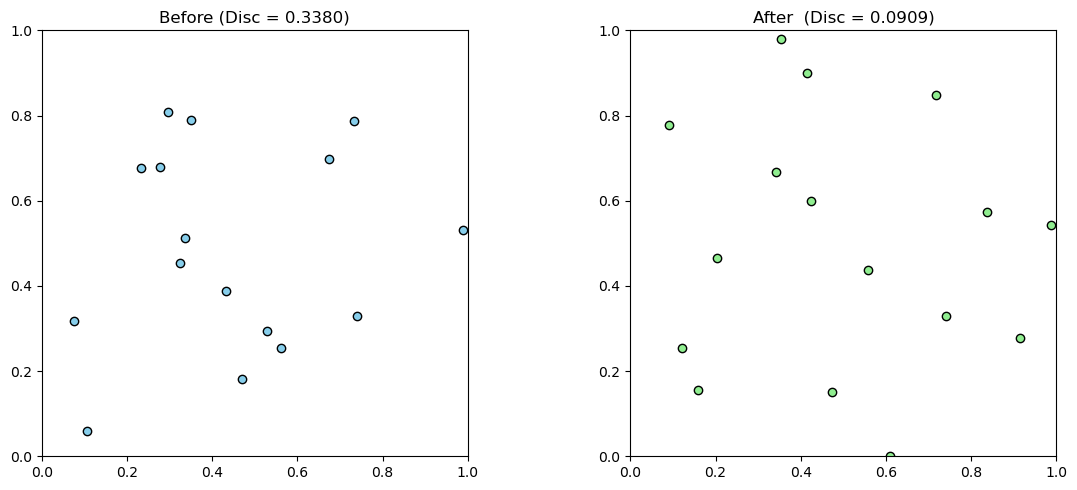

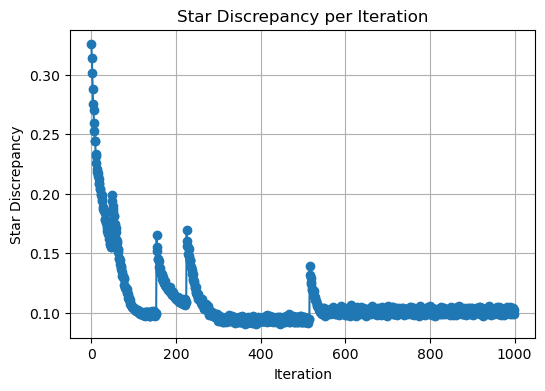

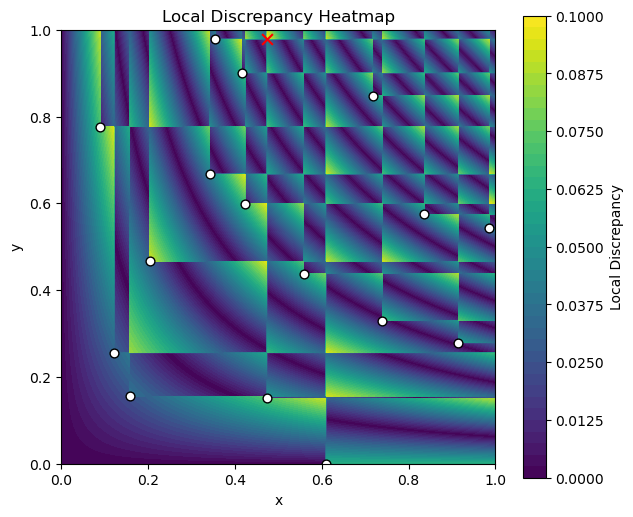

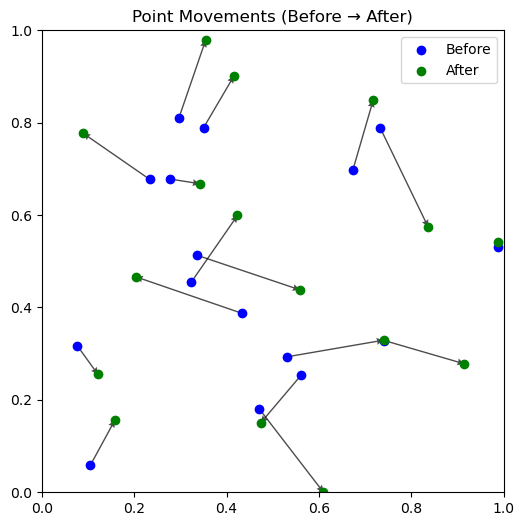

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------
# 1) Discrepancy & penalty utilities
# ---------------------------------------
def star_disc(P):
    n = P.shape[0]
    pts_ext = np.vstack([P, [1.0, 1.0]])
    disc = 0.0
    for i in range(n+1):
        for j in range(n+1):
            x, y = pts_ext[i,0], pts_ext[j,1]
            c1 = np.sum((P[:,0] <= x) & (P[:,1] <= y))/n - x*y
            c2 = x*y - np.sum((P[:,0] <  x) & (P[:,1] <  y))/n
            disc = max(disc, c1, c2)
    return disc

def bump_penalty(P):
    n = P.shape[0]
    r0 = np.sqrt(1/n)
    # vectorized pairwise distances
    D = np.linalg.norm(P[:,None,:] - P[None,:,:], axis=2)
    iu = np.triu_indices(n, k=1)
    U = D[iu] / r0
    mask = U < 1
    return np.sum(np.exp(1/(U[mask]**2 - 1)))

def objective_with_bump(P, alpha):
    return star_disc(P) + alpha * bump_penalty(P)

def project_to_unit_cube(P):
    return np.clip(P, 0, 1 - 1e-8)

def heatmap_from_array(P):
    X = np.linspace(0,1,1001)
    Y = X.copy()
    Z = np.zeros((1001,1001))
    n = P.shape[0]
    for i, xi in enumerate(X):
        for j, yj in enumerate(Y):
            no = np.sum((P[:,0] <  xi) & (P[:,1] <  yj))
            nc = np.sum((P[:,0] <= xi) & (P[:,1] <= yj))
            Z[j,i] = max(xi*yj - no/n, nc/n - xi*yj)
    plt.figure(figsize=(7,6))
    cs = plt.contourf(X, Y, Z, levels=40, cmap="viridis")
    plt.colorbar(cs, label="Local Discrepancy")
    plt.scatter(P[:,0], P[:,1], c="white", s=40, edgecolors="k")
    jm, im = np.unravel_index(Z.argmax(), Z.shape)
    plt.scatter(X[im], Y[jm], c="red", s=60, marker="x")
    plt.title("Local Discrepancy Heatmap")
    plt.xlabel("x"); plt.ylabel("y")
    plt.gca().set_aspect("equal")
    plt.show()

# ---------------------------------------
# 2) PGD + noise on plateau
# ---------------------------------------
def PGD_bump_with_noise(P0, lr=1e-2, alpha=0, steps=500,
                       delta=1e-10, thr=1e-5, noise_scale=0.05):
    P = P0.copy()
    history = []
    prev_disc = star_disc(P)

    for t in range(steps):
        # finite-difference gradient
        grad = np.zeros_like(P)
        for i in range(P.shape[0]):
            for j in range(2):
                orig = P[i,j]
                P[i,j] = orig + delta
                f_plus  = objective_with_bump(P, alpha)
                P[i,j] = orig - delta
                f_minus = objective_with_bump(P, alpha)
                grad[i,j] = (f_plus - f_minus) / (2*delta)
                P[i,j] = orig

        # descent + projection
        P -= lr * grad
        P = project_to_unit_cube(P)

        # check discrepancy
        curr_disc = star_disc(P)
        history.append(curr_disc)

        # if plateau, add noise
        if abs(curr_disc - prev_disc) < thr:
            P += np.random.normal(scale=noise_scale, size=P.shape)
            P = project_to_unit_cube(P)

        prev_disc = curr_disc

    return P, history

# ---------------------------------------
# 3) Run & plotting
# ---------------------------------------
np.random.seed(69)
n = 16
P0 = np.random.rand(n,2)

initial_disc = star_disc(P0)
P_opt, history = PGD_bump_with_noise(P0,
                                    lr=1e-2,
                                    alpha=0e-1,
                                    steps=1000,
                                    delta=1e-10,
                                    thr=1e-5,
                                    noise_scale=0.05)
best_iter = np.argmin(history) + 1
best_disc = history[best_iter-1]

# — Plot 1: Before vs After
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(P0[:,0], P0[:,1], c="skyblue", edgecolor="k")
plt.title(f"Before (Disc = {initial_disc:.4f})")
plt.gca().set_aspect("equal")
plt.xlim(0,1); plt.ylim(0,1)

plt.subplot(1,2,2)
plt.scatter(P_opt[:,0], P_opt[:,1], c="lightgreen", edgecolor="k")
plt.title(f"After  (Disc = {best_disc:.4f})")
plt.gca().set_aspect("equal")
plt.xlim(0,1); plt.ylim(0,1)
plt.tight_layout()
plt.show()

# — Plot 2: Discrepancy History
plt.figure(figsize=(6,4))
plt.plot(history, marker="o", linestyle="-")
plt.title("Star Discrepancy per Iteration")
plt.xlabel("Iteration"); plt.ylabel("Star Discrepancy")
plt.grid(True)
plt.show()

# — Plot 3: Heatmap
heatmap_from_array(P_opt)

# — Plot 4: Movements with arrows
plt.figure(figsize=(6,6))
plt.scatter(P0[:,0], P0[:,1], c="blue",  label="Before", zorder=2)
plt.scatter(P_opt[:,0], P_opt[:,1], c="green", label="After",  zorder=2)
dx = P_opt[:,0] - P0[:,0]
dy = P_opt[:,1] - P0[:,1]
plt.quiver(P0[:,0], P0[:,1], dx, dy,
           angles='xy', scale_units='xy', scale=1,
           width=0.003, headwidth=5, alpha=0.7, zorder=1)
plt.title("Point Movements (Before → After)")
plt.legend()
plt.gca().set_aspect("equal")
plt.xlim(0,1); plt.ylim(0,1)
plt.show()

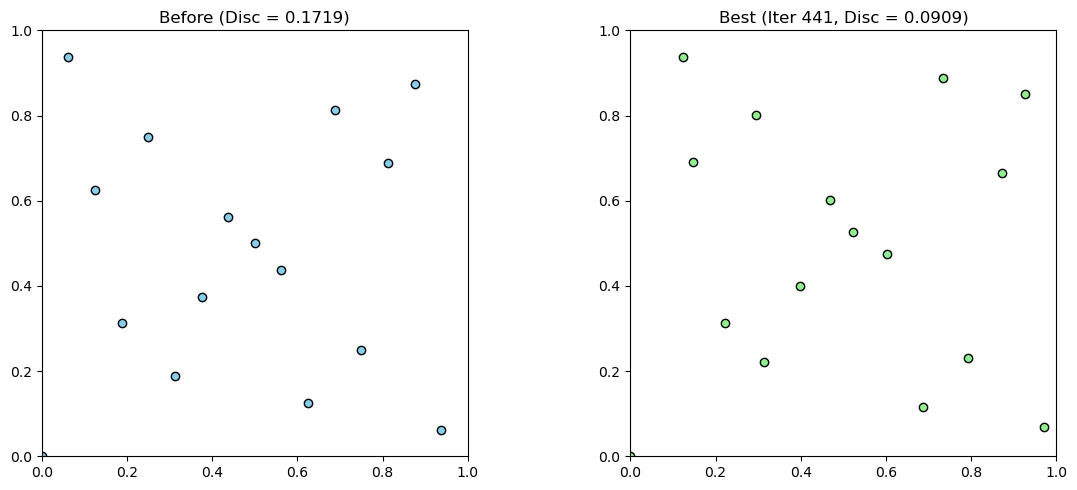

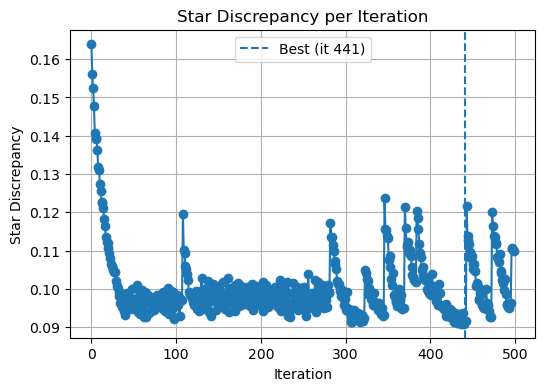

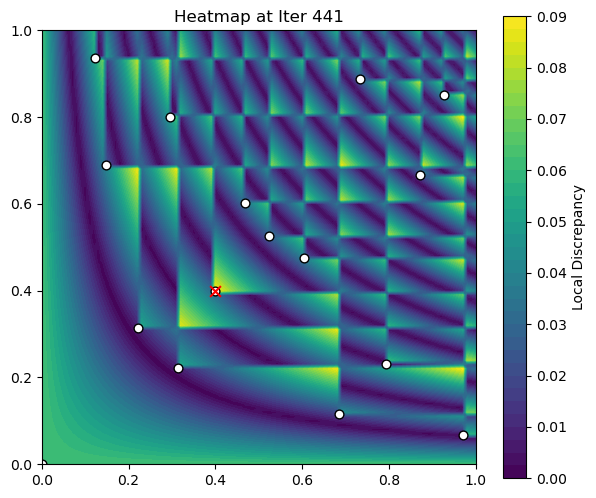

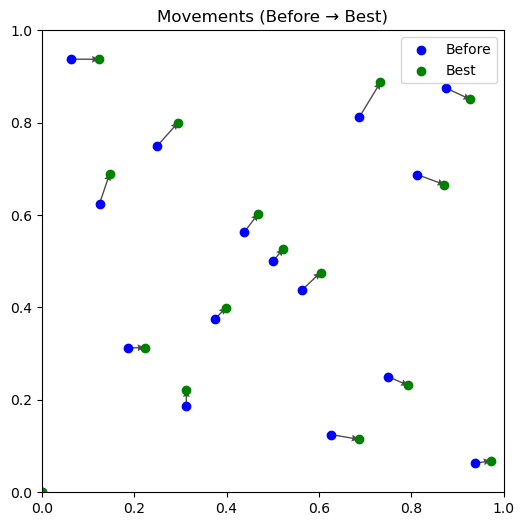

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

# Sobol initializer
def sobol_points(n, scramble=False):
    sampler = qmc.Sobol(d=2, scramble=scramble)
    return sampler.random(n)

# Discrepancy & penalty utilities
def star_disc(P):
    n = P.shape[0]
    pts_ext = np.vstack([P, [1.0, 1.0]])
    disc = 0.0
    for i in range(n+1):
        for j in range(n+1):
            x, y = pts_ext[i,0], pts_ext[j,1]
            c1 = np.sum((P[:,0] <= x) & (P[:,1] <= y))/n - x*y
            c2 = x*y - np.sum((P[:,0] <  x) & (P[:,1] <  y))/n
            disc = max(disc, c1, c2)
    return disc

def bump_penalty(P):
    n = P.shape[0]
    r0 = np.sqrt(1/n)
    D = np.linalg.norm(P[:,None,:] - P[None,:,:], axis=2)
    iu = np.triu_indices(n, k=1)
    U = D[iu] / r0
    mask = U < 1
    return np.sum(np.exp(1/(U[mask]**2 - 1)))

def objective_with_bump(P, alpha):
    return star_disc(P) + alpha * bump_penalty(P)

def project_to_unit_cube(P):
    return np.clip(P, 0, 1 - 1e-8)

# PGD + noise, tracking best iteration
def PGD_bump_noise_best(P0, lr=1e-2, alpha=0, steps=500,
                        delta=1e-5, thr=4e-5, noise_scale=0.02):
    P = P0.copy()
    history = []
    best_P = P.copy()
    best_disc = star_disc(P)
    prev_disc = best_disc

    for t in range(steps):
        grad = np.zeros_like(P)
        for i in range(P.shape[0]):
            for j in range(2):
                orig = P[i,j]
                P[i,j] = orig + delta
                f_plus  = objective_with_bump(P, alpha)
                P[i,j] = orig - delta
                f_minus = objective_with_bump(P, alpha)
                grad[i,j] = (f_plus - f_minus) / (2*delta)
                P[i,j] = orig

        P -= lr * grad
        P = project_to_unit_cube(P)

        curr_disc = star_disc(P)
        history.append(curr_disc)

        if curr_disc < best_disc:
            best_disc = curr_disc
            best_P = P.copy()

        if abs(curr_disc - prev_disc) < thr:
            P += np.random.normal(scale=noise_scale, size=P.shape)
            P = project_to_unit_cube(P)
        prev_disc = curr_disc

    return best_P, history

# Run & visualize with Sobol points
np.random.seed(1)
n = 16
P0 = sobol_points(n)

initial_disc = star_disc(P0)
P_best, history = PGD_bump_noise_best(P0)
best_iter = np.argmin(history) + 1
best_disc = history[best_iter-1]

# Plot Before vs Best
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(P0[:,0], P0[:,1], c="skyblue", edgecolor="k")
plt.title(f"Before (Disc = {initial_disc:.4f})")
plt.gca().set_aspect("equal"); plt.xlim(0,1); plt.ylim(0,1)

plt.subplot(1,2,2)
plt.scatter(P_best[:,0], P_best[:,1], c="lightgreen", edgecolor="k")
plt.title(f"Best (Iter {best_iter}, Disc = {best_disc:.4f})")
plt.gca().set_aspect("equal"); plt.xlim(0,1); plt.ylim(0,1)
plt.tight_layout()
plt.show()

# Plot Discrepancy History
plt.figure(figsize=(6,4))
plt.plot(history, marker="o")
plt.axvline(best_iter, linestyle="--", label=f"Best (it {best_iter})")
plt.title("Star Discrepancy per Iteration")
plt.xlabel("Iteration"); plt.ylabel("Star Discrepancy")
plt.legend(); plt.grid(True)
plt.show()

# Plot Heatmap at best iteration
def heatmap_from_array(P, grid_size=101):
    X = np.linspace(0,1,grid_size)
    Y = X.copy()
    Z = np.zeros((grid_size,grid_size))
    n = P.shape[0]
    for i, xi in enumerate(X):
        for j, yj in enumerate(Y):
            no = np.sum((P[:,0] <  xi) & (P[:,1] <  yj))
            nc = np.sum((P[:,0] <= xi) & (P[:,1] <= yj))
            Z[j,i] = max(xi*yj - no/n, nc/n - xi*yj)
    plt.figure(figsize=(7,6))
    cs = plt.contourf(X, Y, Z, levels=40, cmap="viridis")
    plt.colorbar(cs, label="Local Discrepancy")
    plt.scatter(P[:,0], P[:,1], c="white", s=40, edgecolors="k")
    jm, im = np.unravel_index(Z.argmax(), Z.shape)
    plt.scatter(X[im], Y[jm], c="red", s=60, marker="x")
    plt.title(f"Heatmap at Iter {best_iter}")
    plt.gca().set_aspect("equal")
    plt.show()

heatmap_from_array(P_best)

# Plot Movement Arrows
plt.figure(figsize=(6,6))
plt.scatter(P0[:,0], P0[:,1], c="blue",  label="Before", zorder=2)
plt.scatter(P_best[:,0], P_best[:,1], c="green", label="Best",  zorder=2)
dx = P_best[:,0] - P0[:,0]
dy = P_best[:,1] - P0[:,1]
plt.quiver(P0[:,0], P0[:,1], dx, dy,
           angles='xy', scale_units='xy', scale=1,
           width=0.003, headwidth=5, alpha=0.7, zorder=1)
plt.title("Movements (Before → Best)")
plt.legend()
plt.gca().set_aspect("equal"); plt.xlim(0,1); plt.ylim(0,1)
plt.show()